# Step 1: Identify the problem/ interest

The controversial issue used here is the link between MMR vaccine and Autsim.
I am interested in understanding how online users expresses their opinions towerds such issues.
I would like to test if I can predict the sentiment of a tweet discussing a controversial issue.

This can help with automatilcy detecting how online users online are polirzed in a certin topic, 
which is a strong predeciter for misinformation.

Query words used to collect the data from CH:
("Vaccinations" OR "vaccination" OR "vaccines" OR "vaccine"
OR "measles-mumps-rubella" OR "MMR" OR "mmr") AND
("autism" OR "autistic disorder")

# Step 2: Import important libraries

In [17]:
import nltk
from nltk.corpus import stopwords
import os
import pandas as pd
import csv
import re
import string
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from collections import Counter 
from nltk.tokenize import RegexpTokenizer


In [6]:
# change the seeting of the cells
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# Step 3: Read data file

In [3]:
# read csv file and save it in a data frame
data_df=pd.read_csv('Twitter_Data.csv') # this data colleted from CH

# Step 4: Explore that data

In [4]:
len(data_df)

45319

In [7]:
data_df.tail()

GUID     Date (CST)  \
45314  7.390000e+17  6/4/16 0:11     
45315  8.060000e+17  12/6/16 10:35   
45316  7.140000e+17  3/26/16 0:27    
45317  7.680000e+17  8/24/16 9:34    
45318  6.850000e+17  1/8/16 8:10     

                                                            URL  \
45314  http://twitter.com/ZyenPhilly/status/738961270519402496    
45315  http://twitter.com/zyklonbeast/status/806175176488587264   
45316  http://twitter.com/zzchechi/status/713598175450423296      
45317  http://twitter.com/zzelda01/status/768456377555521536      
45318  http://twitter.com/zztop62/status/685463684009820160       

                                                                                                                                        Contents  \
45314  This Kid Collected All The Evidence Showing Vaccines Cause Autism: This science whiz has had enough.\r\r... https://t.co/RmwXTJ6Ck9         
45315  @mrbones_returns @ChateauEmissary Yeah I think there's a pretty good amount of evidence that a lot of autism is caused by vaccines          
45316  Vaccines causes autism guys don't forget /s                                                                                                 
45317  Scientists are linking chemicals produced in the 1970s to increased autism today�not vaccines https://t.co/eJDcTpHU6u                       
45318  @realDonaldTrump Clinton unveiled her plan to support people with autism. How about you Mr Trump? Please abolish The Vaccine Court = Joke   

             Author                  Name                   Country  \
45314  @ZyenPhilly   Zyen                  United States of America   
45315  @zyklonbeast  .*_.__boxghost_.�_.   United States of America   
45316  @zzchechi     Johnathan Ozuna       United States of America   
45317  @zzelda01     zzelda01 Read my BIO  United States of America   
45318  @zztop62      Sandy Waters          United States of America   

       State/Region City/Urban Area        Category  Emotion   Source  \
45314  Pennsylvania  Philadelphia    Basic Neutral   NaN      Twitter   
45315  Colorado      NaN             Basic Positive  Fear     Twitter   
45316  Florida       NaN             Basic Neutral   Fear     Twitter   
45317  NaN           NaN             Basic Neutral   Fear     Twitter   
45318  Illinois      Chicago         Basic Negative  Disgust  Twitter   

       Klout Score Gender   Posts  Followers  Following  
45314  18.0         NaN    3468    203        284        
45315  52.0         NaN    8797    1010       1171       
45316  40.0         M      48075   459        437        
45317  54.0         NaN    113743  6355       6331       
45318  27.0         F      1433    639        1983

In [62]:
data_df.describe()

GUID   Klout Score         Posts     Followers      Following
count  4.531900e+04  43948.000000  4.531900e+04  4.531900e+04   45319.000000
mean   7.444528e+17     42.896946  4.300492e+04  8.821967e+03    3156.895827
std    3.468479e+16     13.063061  1.118546e+05  1.983248e+05   12384.827740
min    6.830000e+17     10.000000  1.000000e+00  0.000000e+00       0.000000
25%    7.170000e+17     35.000000  3.373000e+03  1.960000e+02     211.500000
50%    7.380000e+17     44.000000  1.076400e+04  6.760000e+02     620.000000
75%    7.720000e+17     52.000000  3.740300e+04  2.317500e+03    1939.000000
max    8.110000e+17     99.000000  2.073004e+06  2.582353e+07  501237.000000

In [63]:
tweets_by_state = data_df['State/Region'].value_counts()

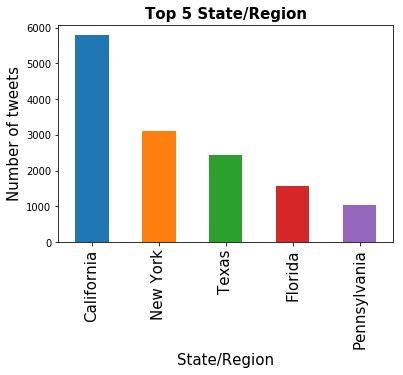

In [67]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('State/Region', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 State/Region', fontsize=15, fontweight='bold')
tweets_by_state[:5].plot(ax=ax, kind='bar')

In [68]:
sentiment = data_df['Category'].value_counts()

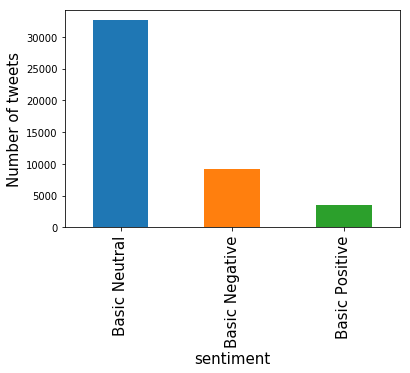

In [69]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('sentiment', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
sentiment.plot(ax=ax, kind='bar')

In [ ]:
# make the data smaller for quicker analysis
data_df=data_df[:10000]

# Step 5: Preprocess the data / clean the data

first, we build a method that can process each tweet

In [8]:
#start processing the tweet
def processPost(tweet):

    # lowercase the tweet
    tweet=tweet.lower()
    
    #Convert www.* or https?://* to " "
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    #Convert @username to " "
    tweet = re.sub('(?<=^|(?<=[^a-zA-Z0-9-_.]))@([_A-Za-z]+[A-Za-z0-9]+)', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Replace @username with empty string
    tweet = re.sub('@[^\s]', '', tweet)
    
    tweet = tweet.replace('\'', '')
    
    #Remove punctuation
    tweet=tweet.translate(None, string.punctuation)
    tweet = re.sub("[\n,\d;:()\!?\-\{}.\"@#*+=%$^&]", " ", tweet)
    
    #remove numbers
    tweet = re.sub("[^a-zA-Z]", ' ', tweet)
    
    #tokenizing the string
    tokens= word_tokenize(tweet) 
    
    stop_words= set(stopwords.words('english'))
    #replace words that have repeated letters and remove stop words
    word_list=''
    for tok in tokens:
        if tok not in stop_words: 
            tok=replaceTwoOrMore(tok)
            word_list=word_list+" "+tok
        
    tweet = word_list
    
    
    
    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    
    #trim
    tweet = tweet.strip('\'"')
    
    return tweet


#look for 2 or more repetitions of character and replace with the character itself
def replaceTwoOrMore(s):
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

In [9]:
# apply the method in all the text and creat another cloumn with the processed text
data_df["clean text"] = data_df['Contents'].apply(lambda x: processPost(x))

In [11]:
# check the new column
data_df["clean text"]

0         beautiful song kelbrynn never receive autism juice vaccines                                                                               
1         holistic doctors researching autism detected cancer enzymes vaccines assassinated liberty beacon                                          
2         body doctor linked vaccines autism found floating river                                                                                   
3         episode idiot parents thinking vaccinations bad cause autism stupidity never ceases amaze                                                 
4         mention theres actually scientific proof link autism vaccinations                                                                         
5         ironically rise autism directly correlates measles mumps rubella taken part part vaccine                                                  
6         oh love vaccinations lead autism wheres research told                                           

# Step 6: Understand the data


In [18]:
tokenizer = RegexpTokenizer(r'\w+')
data_df["tokens"] = data_df["clean text"].apply(tokenizer.tokenize)

In [19]:
data_df.head()

GUID     Date (CST)  \
0  7.250000e+17  4/25/16 12:00   
1  6.890000e+17  1/16/16 17:58   
2  7.970000e+17  11/10/16 8:26   
3  7.050000e+17  3/3/16 14:34    
4  7.780000e+17  9/18/16 20:29   

                                                            URL  \
0  http://twitter.com/_____Max___/status/724644266488795136       
1  http://twitter.com/____cprlivefree/status/688510670149521408   
2  http://twitter.com/___adrienne___/status/796720580955344896    
3  http://twitter.com/___Cady/status/705491506271023104           
4  http://twitter.com/___malice____/status/777681089984733184     

                                                                                                                                     Contents  \
0  @makenzie_scott my beautiful song Kelbrynn will never receive Autism Juice ("vaccines")                                                      
1  Holistic Doctors Researching Autism Detected Cancer Enzymes in Vaccines, Assassinated | The Liberty Beacon https://t.co/K3BSrOTrE0           
2  Body Of Doctor Who Linked Vaccines To Autism, Found Floating In River https://t.co/CzCthTmU78                                                
3  This episode of @nbcsvu is all about idiot parents thinking vaccinations are "bad" and "cause autism". Stupidity never ceases to amaze me.   
4  @millerashley19 not to mention there's actually no scientific proof of a link between autism and vaccinations so...                          

             Author                 Name                   Country  \
0  @_____Max___      Haha, but seriously  United States of America   
1  @____cprlivefree  Ann Behr             United States of America   
2  @___adrienne___   Adrienne Germany     United States of America   
3  @___Cady          Africa               United States of America   
4  @___malice____    maryalice werner     United States of America   

  State/Region City/Urban Area        Category Emotion   Source  Klout Score  \
0  Ohio         NaN             Basic Positive  Joy     Twitter NaN            
1  NaN          NaN             Basic Neutral   Joy     Twitter  55.0          
2  Texas        Houston         Basic Neutral   Fear    Twitter  29.0          
3  Indiana      NaN             Basic Negative  NaN     Twitter  39.0          
4  Texas        Corpus Christi  Basic Neutral   NaN     Twitter  39.0          

  Gender  Posts  Followers  Following  \
0  NaN    6844   317        495         
1  F      24240  1779       1426        
2  F      78227  303        82          
3  NaN    21420  322        73          
4  NaN    14759  302        248         

                                                                                          clean text  \
0   beautiful song kelbrynn never receive autism juice vaccines                                        
1   holistic doctors researching autism detected cancer enzymes vaccines assassinated liberty beacon   
2   body doctor linked vaccines autism found floating river                                            
3   episode idiot parents thinking vaccinations bad cause autism stupidity never ceases amaze          
4   mention theres actually scientific proof link autism vaccinations                                  

                                                                                                         tokens  
0  [beautiful, song, kelbrynn, never, receive, autism, juice, vaccines]                                          
1  [holistic, doctors, researching, autism, detected, cancer, enzymes, vaccines, assassinated, liberty, beacon]  
2  [body, doctor, linked, vaccines, autism, found, floating, river]                                              
3  [episode, idiot, parents, thinking, vaccinations, bad, cause, autism, stupidity, never, ceases, amaze]        
4  [mention, theres, actually, scientific, proof, link, autism, vaccinations]

In [86]:
all_words = [word for tokens in data_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data_df["tokens"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

424537 words total, with a vocabulary size of 19427
Max sentence length is 20


In [87]:
Counter = Counter(all_words)

In [88]:
Counter.most_common(10)

[('autism', 43407),
 ('vaccines', 29289),
 ('cause', 12514),
 ('vaccine', 9341),
 ('cdc', 6448),
 ('vaxxed', 4862),
 ('link', 4016),
 ('via', 3878),
 ('mmr', 3581),
 ('cdcwhistleblower', 2974)]

# Step 7: prepare the data for WEKA

In [92]:
tweet_df=data_df[["clean text","Posts","Followers","Following","Category"]]

In [93]:
tweet_df.head()

clean text  Posts  Followers  \
0   beautiful song kelbrynn never receive autism ...   6844        317   
1   holistic doctors researching autism detected ...  24240       1779   
2   body doctor linked vaccines autism found floa...  78227        303   
3   episode idiot parents thinking vaccinations b...  21420        322   
4   mention theres actually scientific proof link...  14759        302   

   Following        Category  
0        495  Basic Positive  
1       1426   Basic Neutral  
2         82   Basic Neutral  
3         73  Basic Negative  
4        248   Basic Neutral

In [ ]:
# save the data to csv file
tweet_df.to_csv('tweet_df.csv',index= False)